# Redes Convolucionales en visión por computadoras

## Trabajo Final: Analizando el Amazonas desde el espacio

En este trabajo, utilizaremos imágenes satelitales del Amazonas para entrenar un modelo de Deep Learning que sea capaz de darnos información acerca del contenido de las mismas.

### Imágenes

Trabajaremos con más de 40.000 imágenes satelitales en RGB donde cada píxel representa un área de 3.7 metros. Los datos provienen de los satélites Flock 2 de la compañía Planet, recolectados entre el 1 de Enero de 2016 y el 1 de Febrero de 2017. Todas las escenas provienen de la cuenca del Amazonas que incluye Brasil, Perú, Uruguay, Colombia, Venezuela, Guyana, Bolivia y Ecuador.

### Etiquetas

Las clases a predecir para cada imágen representan un conjunto de fenómenos de interés que se desean analizar en el Amazonas. Estas etiquetas pueden distribuirse en tres grupos:

- Condiciones atmosféricas
- Fenómenos comunes de cobertura/uso de suelo
- Fenómenos raros de cobertura/uso de suelo

Cada imágen tendrá al menos una, y potencialmente, más de una etiqueta del tipo de condiciones atmosféricas. Así como también cero o varias etiquetas del tipo de fenómenos comunes o raros de cobertura/uso de suelo. Aquellas imágenes etiquetadas como "cloudy" (nublado), no deberían tener ninguna otra anotación, aunque pueden haber errores de anotación.

Puede ocurrir que en muchas imágenes no se haya taggeado todos los fenómenos observables, como así también puede que haya etiquetas incorrectas. El poder trabajar y solucionar problemas relacionados con datos ruidosos será parte del desafío.

![chips.jpg](attachment:chips.jpg)
*Ejemplo de imágenes y sus etiquetas*

Trabajaremos con un total de 17 etiquetas posibles, descritas a continuación:

- **Cloudy:** Imagen completamente nublada que no permite obtener observaciones adicionales.
- **Partly Cloudy:** Imagen parcialmente nublada.
- **Clear:** Imagen sin nubes.
- **Haze:** Imagen con neblina.
- **Primary (rainforest):** Presencia de bosque "virgen" o áreas con alta densidad de vegetación.
- **Water:** Presencia de ríos, embalses o lagos.
- **Habitation:** Presencia de casas o edificios.
- **Agriculture:** Porciones de tierra sin árboles siendo utilizadas para la agricultura.
- **Road:** Caminos o rutas.
- **Cultivation:** Es un subconjunto de Agriculture que se refiere a pequeñas granjas siendo explotadas por una persona o familia como medio de supervivencia.
- **Bare Ground:** Áreas sin presencia de árboles por causas naturales y no como resultado de la actividad humana.
- **Slash and Burn:** Áreas que han sido incendiadas recientemente.
- **Selective Logging:** Zonas de tala selectiva de especies de árboles de alto valor.
- **Blooming:** Es un fenómeno natural donde ciertas especies de árboles, eclosionan, dan frutos y florecen para aumentar las chances de polinización cruzada.
- **Conventional Mining:** Zona con presencia de minería legal a larga escala.
- **"Artisinal" Mining:** Operaciones de minería a baja escala, usualmente ilegales.
- **Blow Down:** Fenómeno natural que ocurre cuando el aire frío y seco de los Andes se asienta sobre el aire cálido y húmedo en la selva. Estos fuertes vientos derriban los árboles más grandes de la selva tropical, y las áreas abiertas resultantes son visibles desde el espacio.

### Aclaraciones finales

Tenga en cuenta que este no se trata de un problema de multi-class classification, sino un problema de [multi-label classification](https://en.wikipedia.org/wiki/Multi-label_classification), dónde para cada imágen se puede predecir mas de una categoría o etiqueta.


## Instalación de librerías

Si desea utilizar Google Colab, recomiendo ejecutar este comando para actualizar e instalar la versión 2.0 de `tensorflow-gpu` (la versión instalada por defecto de tensorflow sólo corre en CPU).

In [0]:
!pip uninstall tensorflow && pip install -U tensorflow-gpu==2.0.0 keras==2.3.1

## Obtención de datos

Para descargar las imágenes y sus correspondientes etiquetas, puede ejecutar los siguiente comandos directamente desde el notebook.

In [0]:
# Descargar dataset de imágenes desde Google Drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1--zzWhWfDnSZMtIcUfMyc10ZZPH3ZdnM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1--zzWhWfDnSZMtIcUfMyc10ZZPH3ZdnM" -O 'train-jpg.tar' && rm -rf /tmp/cookies.txt

In [0]:
# Extraemos las imágenes
!tar -xvf train-jpg.tar

In [0]:
# Descargar etiquetas desde Google Drive
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1UB3LTf73QrXggGQqzUCLjntxmfA90aDb' -O 'train-jpg-labels.pkl'

## Librerias a utilizar

Es obligatorio el uso de `Keras` y `tensorflow` para la creación y entrenamiento de su modelo de Deep Learning.

In [0]:
import warnings

from IPython.display import SVG
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from keras.models import Sequential
from keras.utils import plot_model, to_categorical
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter

warnings.filterwarnings('ignore')
%matplotlib inline

## Exploración y análisis

Utilice esta sección para explorar las imágenes y sus etiquetas asociadas. Sugerencias:

- Analice la distribución de los datos.
    - ¿Está el dataset balanceado?
    - ¿Cuál es el tamaño de las imágenes?
- Analice la correlación entre etiquetas.
- Visualice imágenes y relaciones patrones presentes en cada una.

**Ayuda:** Para cargar las etiquetas recomiendo utilizar la función [read_pickle](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_pickle.html) de la librería `Pandas`.

In [0]:
labels = pd.read_pickle("train-jpg-labels.pkl")
labels.head()

,image_name,tags
0,train-jpg/train_0.jpg,"[haze, primary]"
1,train-jpg/train_1.jpg,"[agriculture, clear, primary, water]"
2,train-jpg/train_2.jpg,"[clear, primary]"
3,train-jpg/train_3.jpg,"[clear, primary]"
4,train-jpg/train_4.jpg,"[agriculture, clear, habitation, primary, road]"


In [76]:
tags = []
for tag in labels.tags:
  tags.extend(tag)
tag_ctr = Counter(tags)
tags_ctr = pd.DataFrame.from_dict(tag_ctr, orient="index", columns=["counter"])
display(tags_ctr.sort_values("counter", ascending=False))

,counter
primary,37513
clear,28431
agriculture,12315
road,8071
water,7411
partly_cloudy,7261
cultivation,4547
habitation,3660
haze,2697
cloudy,2089


<BarContainer object of 17 artists>

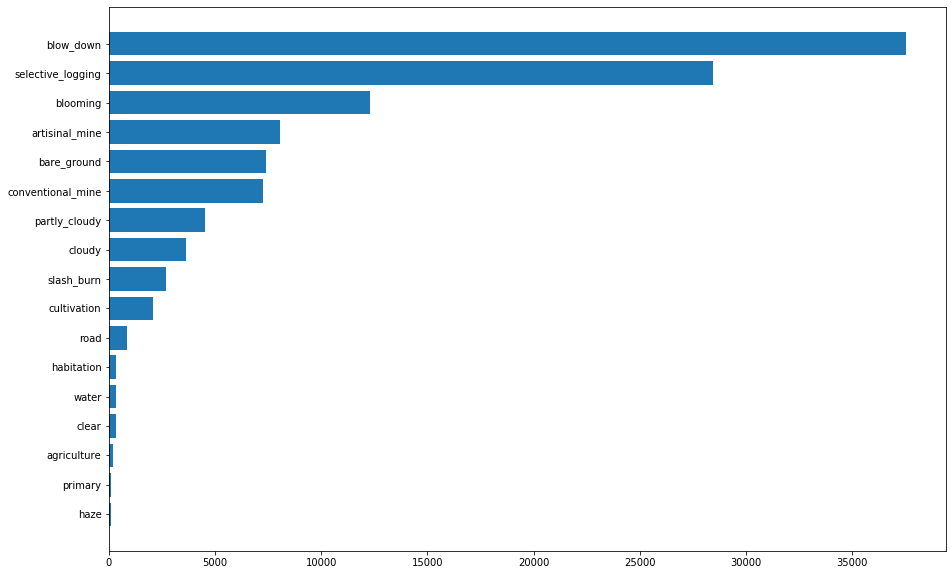

In [100]:
plt.figure(figsize=(15, 10))
plt.barh(width=tags_ctr.counter.sort_values(), y=tags_ctr.T.columns.values)

In [48]:
mpimg.imread('train-jpg/train_0.jpg').shape

(256, 256, 4)

Las imagenes son de 256x256 y son de 4 canales: RGB (3) y Escala de grises (1)

## Conjunto de entrenamiento

En base al análisis anterior, decida como separará sus datos en conjuntos de entrenamiento y testing.

## Data Augmentation

Proponga algún de pre-procesamiento y aumentado de datos, visualice los resultados del método propuesto. Puede experimentar y elegir el que mejor funcione en sus entrenamientos.

**Ayuda:** Al tener sus anotaciones en formato csv, lo mas sensillo sería utilizar el método [flow_from_dataframe](https://keras.io/preprocessing/image/#flow_from_dataframe) de la clase `ImageDataGenerator` de `Keras`.

## Elección de modelo

Elija un modelo de red convolucional para entrenar sobre sus datos. Puede armar su propia red convolucional de cero o utilizar una de las provistas por `Keras` en [Applications](https://keras.io/applications/).

Piense como debería ser la capa de clasificación de su modelo y la función de costo a utilizar durante el entrenamiento al tratarse de un problema del tipo multi-label classification.

## Entrenamiento

Entrene y muestre los resultados obtenidos en cada epoch para con su modelo.

## Evaluación

Muestre debajo los resultados del modelo en su conjunto de testing. Elija las métricas apropiadas para este tipo de problema.